In [23]:
#%pip install wbgapi
import wbgapi as wb
import pandas as pd
import requests
import pandas as pd
from io import StringIO
from datetime import datetime
import math


#%pip install missingno
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # o 'Arial', 'Times New Roman', etc.
import seaborn as sns
import missingno as msno       # Para visualización de valores nulos
import scipy.stats as stats    # Para pruebas estadísticas
from matplotlib.patches import Patch

# 📊 Extracción de datos del Banco Mundial usando el API

En este paso se realiza una selección de **15 variables socioeconómicas**, agrupadas por temática:

## Ciencia y tecnología

- `IP.JRN.ARTC.SC`: Artículos en publicaciones científicas y técnicas  
- `SP.POP.SCIE.RD.P6`: Investigadores dedicados a investigación y desarrollo (por cada millón de personas)  
- `GB.XPD.RSDV.GD.ZS`: Gasto en investigación y desarrollo (% del PIB)  
- `SP.POP.TECH.RD.P6`: Técnicos de investigación y desarrollo (por cada millón de personas)  


## Economía y crecimiento

- `NY.GDP.PCAP.CD`: PIB per cápita (US$ a precios actuales)  

## Educación

- `SE.XPD.TOTL.GD.ZS`: Gasto público en educación, total (% del PIB)  
- `SE.PRM.ENRR`: Inscripción escolar, nivel primario (% bruto)  
- `SE.SEC.ENRR`: Inscripción escolar, nivel secundario (% bruto)  
- `SE.TER.ENRR`: Inscripción escolar, nivel terciario (% bruto)  
- `SE.XPD.TOTL.GB.ZS`: Gasto público en educación, total (% del gasto del gobierno)  

## Cambio climático

- `ER.PTD.TOTL.ZS`: Áreas protegidas terrestres y marinas (% del total de la superficie territorial)  
- `AG.LND.FRST.K2`: Área selvática (kilómetros cuadrados)  


## Ambiente

- `AG.SRF.TOTL.K2`: Superficie (kilómetros cuadrados)  


## Sector público

- `GE.EST`: Government Effectiveness (Estimate)  


## Infraestructura

- `IT.NET.USER.ZS`: Individuos que utilizan Internet (% de la población)


In [24]:
wb.source.info()
wb.economy.info(db=75)


# Lista de variables seleccionadas del Banco Mundial
SEvar = ['GB.XPD.RSDV.GD.ZS','IP.JRN.ARTC.SC', 'SP.POP.SCIE.RD.P6', 'SP.POP.TECH.RD.P6', 'NY.GDP.PCAP.CD', 'SE.XPD.TOTL.GD.ZS', 'SE.XPD.TOTL.GB.ZS', 'SE.PRM.ENRR', 'SE.SEC.ENRR','SE.TER.ENRR', 'ER.PTD.TOTL.ZS', 'AG.LND.FRST.K2', 'AG.SRF.TOTL.K2', 'GE.EST' , 'IT.NET.USER.ZS']


# Países participantes en GBIF
GBIF_countries = ['AND', 'AGO', 'ARG', 'ARM', 'AUS', 'BEL', 'BEN', 'BRA', 'BDI', 'KHM', 'CMR', 'CAN', 'CAF',
 'CHL', 'COL', 'CRI', 'HRV', 'DNK', 'ECU', 'EST', 'FIN', 'FRA', 'GEO', 'DEU', 'GTM', 'GIN',
 'ISL', 'IRL', 'LBR', 'LUX', 'MDG', 'MWI', 'MRT', 'MEX', 'MNG', 'NAM', 'NLD', 'NZL', 'NOR',
 'PAN', 'PER', 'POL', 'PRT', 'SLE', 'SVK', 'SVN', 'ZAF', 'SSD', 'ESP', 'SUR', 'SWE', 'CHE',
 'TJK', 'TGO', 'TON', 'GBR', 'USA', 'URY', 'UZB', 'ZWE']

#Carga de datos con el API del Banco Mundial para los países seleccionados. 
#SE_Col_data= wb.data.DataFrame(SEvar, 'COL', time=range(2000, 2025), labels=True).reset_index()
SEdata= wb.data.DataFrame(SEvar, GBIF_countries, time=range(2000, 2025), labels=True).reset_index()

SEdata.head(5)


# Pivotear y organizar la tabla en un formato legible para el análisis.

# Cargar los datos
SEdata = SEdata.drop(columns=['Series'])

# Aplicar la función Melt para convertir los años de columnas a filas
SEdata_long = SEdata.melt(
    id_vars=["economy", "series", "Country"],
    var_name="Year",
    value_name="Value"
)

# Limpiar el campo Year: eliminar 'YR' y convertir a datetime
SEdata_long["Year"] = SEdata_long["Year"].str.replace("YR", "", regex=False)
SEdata_long["Year"] = pd.to_datetime(SEdata_long["Year"], format="%Y")
SEdata_long["Year"] = SEdata_long["Year"].dt.year  # Extrae solo el año como número

#Pivotear usando los valores de 'Series' como nombres de columna
SEdata_pivot = SEdata_long.pivot_table(
    index=["economy", "Country", "Year"],
    columns="series",
    values="Value",
    aggfunc="first"  # por si hay duplicados
).reset_index()

#  limpiar nombre de columnas si queda jerarquía
SEdata_pivot.columns.name = None



#Countries metadata


# URL de la API para obtener información de países
url = "https://api.worldbank.org/v2/country?format=json&per_page=300"

# Realizar la solicitud GET
response = requests.get(url)
data = response.json()

# Extraer los datos de los países
countries = data[1]  # La segunda parte del JSON contiene la lista de países

# Crear un DataFrame con la información relevante
countries_meta = pd.DataFrame([{
    "id": country["id"],
    "iso2Code": country["iso2Code"],
    "region": country["region"]["value"],
    "incomeLevel": country["incomeLevel"]["value"],
    "lendingType": country["lendingType"]["value"],
   
} for country in countries])

# Mostrar las primeras filas del DataFrame
print(countries_meta.head())



BM_Data = pd.merge(SEdata_pivot, countries_meta, left_on="economy", right_on="id", how="left")
##### Transformaciones

BM_Data  = BM_Data.rename(columns={'Year': 'year'})
BM_Data  = BM_Data.rename(columns={'Country': 'country'})
BM_Data  = BM_Data.rename(columns={'iso2Code': 'countryCode'})
dropcolumns = ['economy','id']
BM_Data = BM_Data.drop(dropcolumns, axis=1)






    id iso2Code                      region  incomeLevel     lendingType
0  ABW       AW  Latin America & Caribbean   High income  Not classified
1  AFE       ZH                  Aggregates   Aggregates      Aggregates
2  AFG       AF                  South Asia   Low income             IDA
3  AFR       A9                  Aggregates   Aggregates      Aggregates
4  AFW       ZI                  Aggregates   Aggregates      Aggregates


# Descripción del código: Extracción, limpieza y unión de datos de GBIF

Este segmento del script descarga, filtra y une automáticamente datos de GBIF, centrados en ocurrencias y especies reportadas en el país y por país publicador.
Finalmente une los cuatro DataFrames usando una unión externa (outer join) por year y countryCode para obtener como resultado una tabla integrada con los conteos por país y año, tanto desde el punto de vista del país donde ocurre la observación como del país que publica.

In [25]:


############################################
# Descargar los datos y generar subset por año y país
############################################

# Parámetros
BASE_URL = "https://analytics-files.gbif.org/global/csv/"
GBIF_FILES = [
    "occ_country.csv",
    "occ_publisherCountry.csv"
    # "spe_country.csv",
    # "spe_publisherCountry.csv"
]
DIAS_UMBRAL = 60  # días alrededor del 31 de diciembre a considerar

# Función para cargar archivos CSV desde URL
def load_csv(filename):
    url = BASE_URL + filename
    try:
        print(f"📥 Cargando {filename} desde: {url}")
        response = requests.get(url)
        response.raise_for_status()
        df = pd.read_csv(StringIO(response.text))
        print(f"✅ {filename} cargado con éxito.")
        return df
    except Exception as e:
        print(f"❌ Error al cargar {filename}: {e}")
        return pd.DataFrame()

# Función para ajustar el año según cercanía a diciembre 31
def ajustar_anio(snapshot, max_dias=DIAS_UMBRAL):
    d31_prev = datetime(snapshot.year - 1, 12, 31)
    d31_curr = datetime(snapshot.year, 12, 31)
    diff_prev = abs((snapshot - d31_prev).days)
    diff_curr = abs((snapshot - d31_curr).days)
    
    if diff_prev <= max_dias and snapshot < d31_curr:
        return snapshot.year - 1
    elif diff_curr <= max_dias:
        return snapshot.year
    else:
        return None

# Función para obtener solo la fecha más cercana a 31 dic por año
def extraer_snapshot_mas_cercano(df, dias_umbral=DIAS_UMBRAL):
    df = df.copy()
    df["snapshot"] = pd.to_datetime(df["snapshot"])
    df["year"] = df["snapshot"].apply(lambda x: ajustar_anio(x, dias_umbral))
    df = df.dropna(subset=["year"])
    
    df["dist_to_d31"] = df.apply(
        lambda row: abs((row["snapshot"] - datetime(int(row["year"]), 12, 31)).days),
        axis=1
    )
    
    df_sorted = df.sort_values(by=["year", "dist_to_d31"])
    fechas_cercanas = df_sorted.groupby("year")["snapshot"].first().reset_index()
    
    df_final = df.merge(fechas_cercanas, on=["year", "snapshot"], how="inner")
    return df_final.drop(columns=["dist_to_d31"])

# Cargar y procesar los archivos seleccionados
dataframes = {}
for filename in GBIF_FILES:
    key = filename.replace(".csv", "")
    df_raw = load_csv(filename)
    if not df_raw.empty:
        dataframes[key] = extraer_snapshot_mas_cercano(df_raw)

globals().update(dataframes)

# Renombrar columnas para merge
occ_publisherCountry.rename(columns={
    'publisherCountry': 'countryCode',
    'occurrenceCount': 'occurrenceCount_publisher'
}, inplace=True)

occ_country.rename(columns={'country': 'countryCode'}, inplace=True)

# Lista de datasets
datasets = [occ_country, occ_publisherCountry]

# Limpieza: eliminar snapshot y filtrar NaNs en countryCode
for i in range(len(datasets)):
    datasets[i] = datasets[i].drop(columns=["snapshot"], errors="ignore")
    datasets[i] = datasets[i].dropna(subset=["countryCode"])

# Merge usando year y countryCode como claves
from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=["year", "countryCode"], how="outer"), datasets)

# Mostrar una vista previa
print(df_merged.head())




📥 Cargando occ_country.csv desde: https://analytics-files.gbif.org/global/csv/occ_country.csv
✅ occ_country.csv cargado con éxito.
📥 Cargando occ_publisherCountry.csv desde: https://analytics-files.gbif.org/global/csv/occ_publisherCountry.csv
✅ occ_publisherCountry.csv cargado con éxito.
  countryCode  occurrenceCount    year  occurrenceCount_publisher
0          AD          13343.0  2007.0                        NaN
1          AE           1192.0  2007.0                        NaN
2          AF          23395.0  2007.0                        NaN
3          AG           3286.0  2007.0                        NaN
4          AI           2372.0  2007.0                        NaN


### Unión de datos socieconómicos y de publicación de biodiversidad

In [26]:
Data = pd.merge(BM_Data, df_merged, on=["year", "countryCode"], how="left")

# Análisis Exploratorio de Datos

In [34]:
EDA_basic = pd.concat([
        Data.describe(include='all').T,
        Data.isnull().sum().rename("Missing"),
        Data.dtypes.rename("Type")
    ], axis=1)

EDA_basic

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,Missing,Type
country,1500,60,Angola,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
year,1500.0,NaN,NaN,NaN,2012.0,7.213507,2000.0,2006.0,2012.0,2018.0,2024.0,0,int64
AG.LND.FRST.K2,1368.0,NaN,NaN,NaN,330847.503669,879032.556909,89.5,12689.485,66399.5,176825.2,5510886.0,132,float64
AG.SRF.TOTL.K2,1368.0,NaN,NaN,NaN,1083790.80916,2684184.374487,470.0,69700.0,243610.0,624499.25,15640500.0,132,float64
ER.PTD.TOTL.ZS,720.0,NaN,NaN,NaN,17.643427,11.667154,0.1,7.6,17.3,24.3,55.8,780,float64
GB.XPD.RSDV.GD.ZS,879.0,NaN,NaN,NaN,1.233292,1.007517,0.01019,0.300665,1.05575,1.984525,3.8738,621,float64
GE.EST,1367.0,NaN,NaN,NaN,0.305873,1.145597,-2.440221,-0.69666,0.218387,1.497468,2.347191,133,float64
IP.JRN.ARTC.SC,1380.0,NaN,NaN,NaN,17877.977239,55542.095638,0.0,65.265,677.445,11458.42,472448.44,120,float64
IT.NET.USER.ZS,1408.0,NaN,NaN,NaN,46.149278,34.235665,0.0177,10.0,46.25,80.0,99.8,92,float64
NY.GDP.PCAP.CD,1423.0,NaN,NaN,NaN,20445.934153,25095.830341,111.406683,1664.649436,7949.888672,37213.020916,133711.794436,77,float64


## Datos faltantes

Para predecir el comportamiento futuro en la publicación de datos se introdujo una variable temporal (_year_), que permitirá construir posteriormente modelos basados en series temporales. En el análisis exploratorio de este tipo de datos, la detección y tratamiento de los datos faltantes constituye un componente crítico, especialmente cuando estas ausencias se presentan en variables objetivo o de interés analítico. A diferencia de los datos faltantes en estructuras tabulares comunes, las series temporales añaden una dimensión adicional asociada a la secuencia y dependencia temporal entre observaciones.

La falta de datos en la serie temporal puede interrumpir patrones estacionales, sesgar tendencias o afectar la calidad de modelos predictivos. Esto es especialmente relevante en este contexto donde las variables objetivo son usadas para hacer inferencias o proyecciones. La ausencia de registros para ciertos años o períodos puede reducir la representatividad de los datos, generar vacíos en los modelos y dificultar la validación de hipótesis.

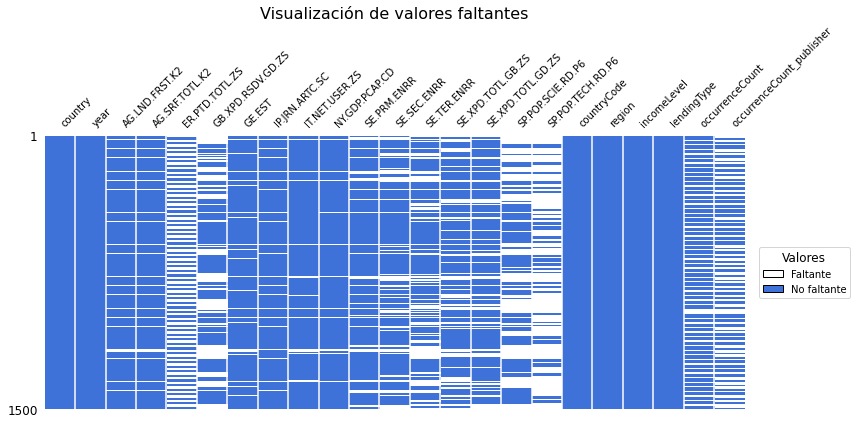

In [35]:
# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 6))
msno.matrix(Data, 
            ax=ax,
            color=(0.25, 0.45, 0.85), 
            sparkline=False,
            fontsize=10)

# Crear leyenda personalizada
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Faltante'),
    Patch(facecolor=(0.25, 0.45, 0.85), edgecolor='black', label='No faltante')
]

# Añadir leyenda fuera del gráfico
ax.legend(
    handles=legend_elements,
    loc='center left',             # Ubicación relativa
    bbox_to_anchor=(1.02, 0.5),    # Fuera a la derecha, centrada verticalmente
    borderaxespad=0,
    title='Valores',
    fontsize=10,
    title_fontsize=12
)

# Título del gráfico
ax.set_title('Visualización de valores faltantes', fontsize=16)

# Ajustar layout para que no se corte la leyenda
plt.tight_layout()
plt.show()

De forma general, se identifica que hay 1,405 filas con almenos un dato faltante, lo que equivale a un 93.7% de las filas del dataset. La variable objetivo que corresponde el número de registos biológicos publicados por país (_occurrenceCountpublisher_) hay 686 registros (46%) que corresponden a datos faltantes. Esto representa un reto pues disminuye el tamaño del _dataset_ y podría afectar la cantidad de datos disponibles para la construcción y evaluación de los modelos. Sin embargo, hay que considerar que estos vacíos, no se deben a falta de información sino principalmente a la fecha en la que cada país ingreso a la red de GBIF o iniciaron con la publicación de datos a través de esta red. 

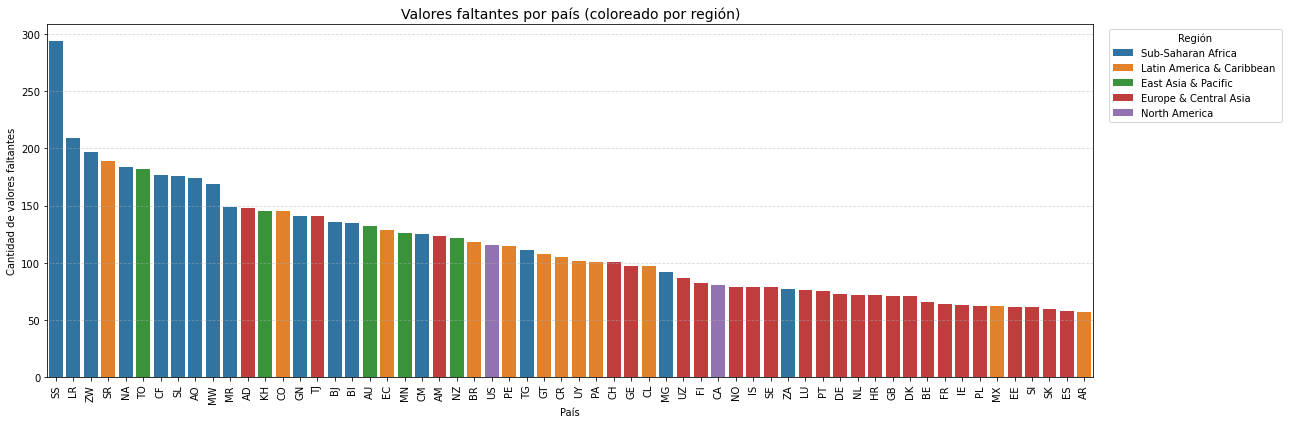

In [ ]:


# Calcular valores faltantes por país
missing_by_country = Data.groupby("countryCode").apply(lambda x: x.isna().sum()).sum(axis=1).reset_index()
missing_by_country.columns = ['countryCode', 'missing_count']

#  Asociar región
country_region = Data[['countryCode', 'region']].drop_duplicates()
missing_by_country = pd.merge(missing_by_country, country_region, on='countryCode', how='left')

#  Ordenar por número de valores faltantes
missing_by_country.sort_values('missing_count', ascending=False, inplace=True)

#  Crear gráfico
plt.figure(figsize=(18, 6))
sns.barplot(data=missing_by_country, x='countryCode', y='missing_count', hue='region', dodge=False)

plt.title("Valores faltantes por país (coloreado por región)", fontsize=14)
plt.xlabel("País")
plt.ylabel("Cantidad de valores faltantes")
plt.xticks(rotation=90)
plt.legend(title='Región', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


El anterior gráfico nos permite identificar cuáles regiones y los respectivos países que presentan el mayor número de datos faltantes. El resultado es que la región del África Subsahariana es la que presenta mayores vacíos, especialmente países como Sudán del Sur. Alguos países de Latinoamérica como Surinam (SR) tienen grandes vacíos de datos. Sin embargo, este es un país que se unió a la red de GBIF en 2023.  

In [44]:
# Calcular porcentaje de celdas vacías por columna
missing_percent = 100 * Data.isna().sum() / len(Data)

# Crear tabla ordenada y redondeada
missing_table = (
    missing_percent[missing_percent > 0]  # Filtrar solo las columnas con faltantes
    .sort_values(ascending=False)         # Ordenar de mayor a menor
    .round(2)                             # Redondear a 2 decimales
    .reset_index()                        # Convertir a DataFrame
)

# Renombrar columnas para presentación
missing_table.columns = ['Variable', 'Porcentaje de valores faltantes (%)']

# Mostrar tabla
print(missing_table.to_string(index=False))


                 Variable  Porcentaje de valores faltantes (%)
        SP.POP.TECH.RD.P6                                70.13
           ER.PTD.TOTL.ZS                                52.00
        SP.POP.SCIE.RD.P6                                49.73
occurrenceCount_publisher                                45.73
        GB.XPD.RSDV.GD.ZS                                41.40
              SE.TER.ENRR                                31.07
          occurrenceCount                                29.20
        SE.XPD.TOTL.GB.ZS                                26.87
              SE.SEC.ENRR                                25.20
        SE.XPD.TOTL.GD.ZS                                21.00
              SE.PRM.ENRR                                15.20
                   GE.EST                                 8.87
           AG.SRF.TOTL.K2                                 8.80
           AG.LND.FRST.K2                                 8.80
           IP.JRN.ARTC.SC                              

**Análisis de los valores faltantes por categoría temática**

Ciencia y tecnología:  Estas variables  presentan los mayores niveles de datos faltantes en el conjunto. Por ejemplo, el porcentaje de vacíos en la variable sobre técnicos dedicados a investigación y desarrollo (SP.POP.TECH.RD.P6) alcanza un 70,13%, mientras que la proporción de investigadores por millón de habitantes (SP.POP.SCIE.RD.P6) muestra un 49,73% de ausencia. A su vez, el gasto en investigación y desarrollo como porcentaje del PIB (GB.XPD.RSDV.GD.ZS) tiene un 41,4% de valores faltantes, y los artículos científicos publicados (IP.JRN.ARTC.SC) un 8%.  Sin embargo, otras variables como los artículos científicos publicados (IP.JRN.ARTC.SC) tiene una relación de vacíos de apenas un 8%. Dada la importancia que se le otorga a este tipo de variables en este estudio, se considera necesario revisar y contemplar otro tipo de variables que puedan apoyar o soportar la hipótesis de la relación del grado de inversión de Ciencia y Tecnnología con el crecimiento en la publicación de datos en GBIF, pues este patrón de datos faltantes limita el análisis comparativo y el estudio de posibles vínculos entre inversión científica y otras dimensiones del desarrollo.

Cambio climático y medio ambiente: La variable que reporta el porcentaje de áreas protegidas terrestres y marinas (ER.PTD.TOTL.ZS) presenta un 52% de datos faltantes. En contraste, otras variables como la cobertura boscosa (AG.LND.FRST.K2) y la superficie total del país (AG.SRF.TOTL.K2) tienen menos del 9% de valores faltantes, lo que las convierte en insumos más confiables para posteriores análisis. Este contraste sugiere que las vinculadas a decisiones políticas (como la creación de áreas protegidas) pueden no estar los suficientemente documentadas para contemplarlas en el modelo.

Educación: La inscripción escolar en el nivel terciario (SE.TER.ENRR) tiene un 31,07% de datos faltantes, mientras que la inscripción en educación secundaria (SE.SEC.ENRR) y primaria (SE.PRM.ENRR) presentan 25,2% y 15,2% respectivamente. Asimismo, los indicadores de gasto público en educación, tanto como porcentaje del PIB (SE.XPD.TOTL.GD.ZS) como del gasto total del gobierno (SE.XPD.TOTL.GB.ZS), muestran vacíos superiores al 20%.

Economía y crecimiento: La variable sobre el PIB per cápita (NY.GDP.PCAP.CD) tiene un nivel relativamente bajo de datos faltantes (5,13%), lo cual es consistente con su importancia en reportes económicos internacionales y la frecuencia con que es actualizada. Esto la convierte en una de las variables más completas y confiables del conjunto.

Infraestructura: El porcentaje de individuos que utilizan internet (IT.NET.USER.ZS) presenta un 6,13% de valores faltantes, lo cual indica una buena cobertura de datos para este indicador. Su estabilidad permite utilizarlo como un proxy útil para analizar aspectos de acceso digital o desarrollo tecnológico en general.

Sector público: La variable que mide la efectividad del gobierno (GE.EST) tiene una tasa de valores faltantes del 8,87%, lo cual, si bien no es despreciable, aún permite su utilización en análisis comparativos. No obstante, su carácter estimado y subjetivo implica considerar también las fuentes y metodologías de cálculo antes de usarla como variable explicativa.

Datos de biodiversidad (GBIF): Cómo se observó anterioremente los datos de ocurrencias de biodiversidad —como occurrenceCount y occurrenceCount_publisher— presentan vacíos importantes (29,2% y 45,73%, respectivamente). Los vacíos en estas variables pueden tener implicaciones importantes en la representatividad de los análisis relacionados con disponibilidad y movilización de datos sobre biodiversidad.

In [ ]:
# Variables numéricas del Banco Mundial
var_BM = [
    'AG.SRF.TOTL.K2',
    'AG.LND.FRST.K2',
    'ER.PTD.TOTL.ZS',
    'GB.XPD.RSDV.GD.ZS',
    'GE.EST',
    'IP.JRN.ARTC.SC',
    'IT.NET.USER.ZS',
    'NY.GDP.PCAP.CD',
    'SE.PRM.ENRR',
    'SE.SEC.ENRR',
    'SE.TER.ENRR',
    'SE.XPD.TOTL.GB.ZS',
    'SE.XPD.TOTL.GD.ZS',
    'SP.POP.SCIE.RD.P6',
    'SP.POP.TECH.RD.P6'
]
var_BM_se = Data[var_BM]

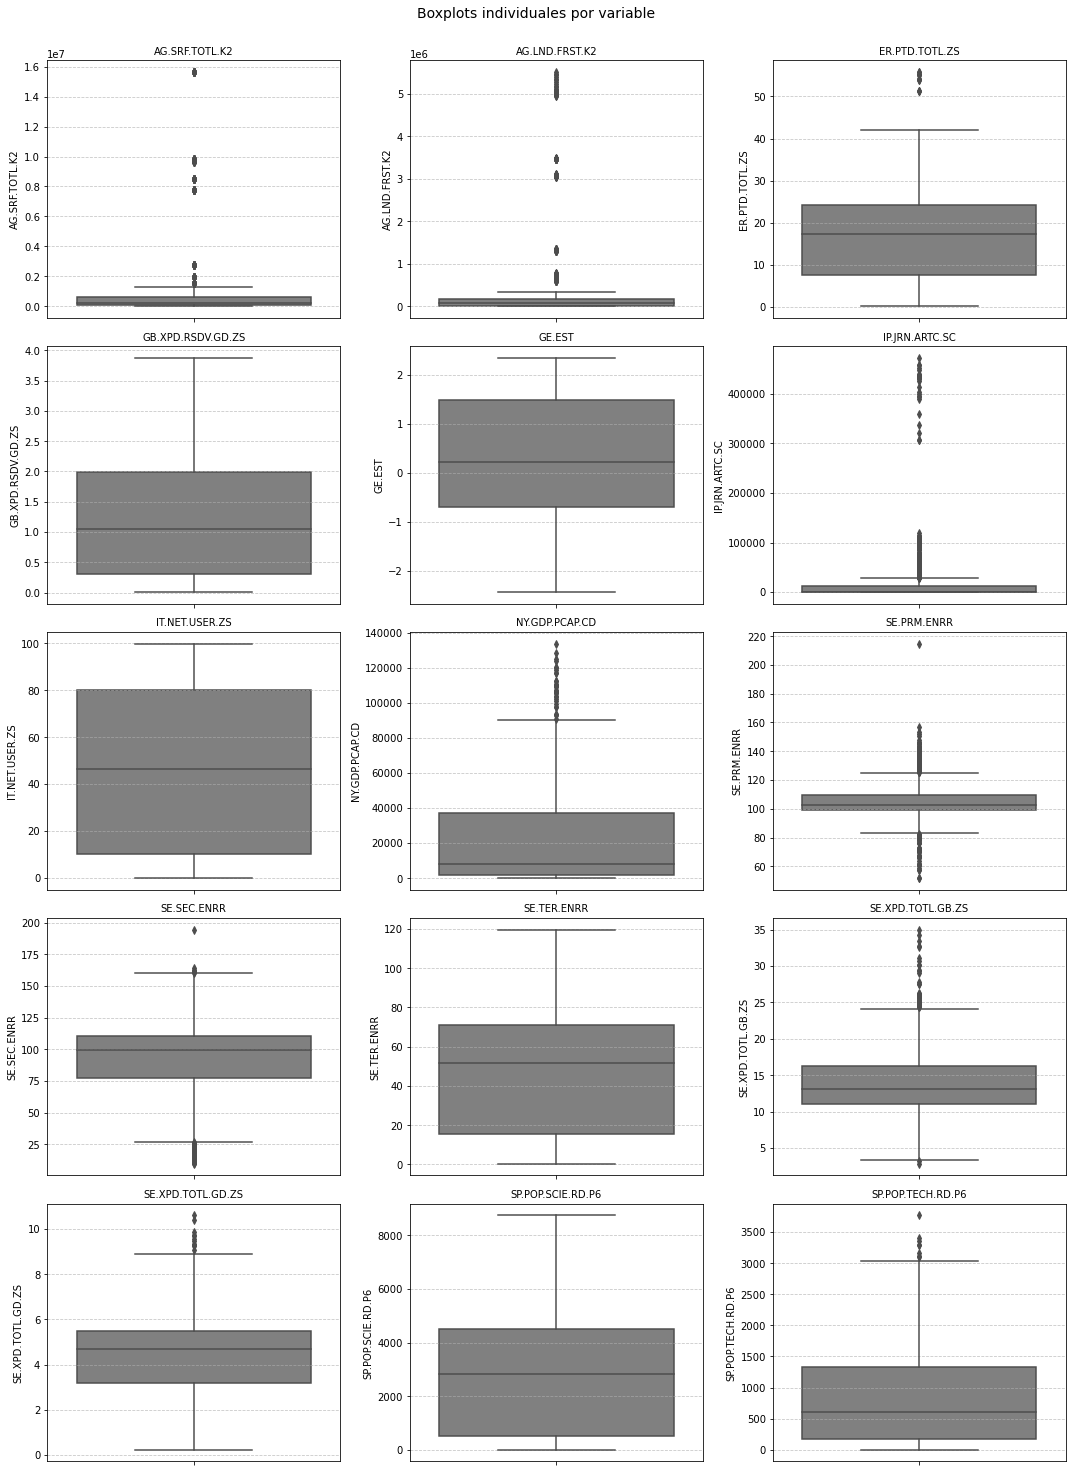

In [37]:
# Número de variables
num_vars = var_BM_se.shape[1]
cols = 3  # Número de columnas en el mosaico
rows = math.ceil(num_vars / cols)

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Crear un boxplot por variable
for i, col in enumerate(var_BM_se.columns):
    sns.boxplot(data=var_BM_se, y=col, ax=axes[i], color='grey')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Boxplots individuales por variable", fontsize=14, y=1.02)
plt.show()


Dentro de las variables socioeconómicas las variables AG.LND.FRST.K2 (Área selvática (kilómetros cuadrados)) y AG.SRF.TOTL.K2 (Superficie (kilómetros cuadrados)) presentan la mayor cantidad de valores atípicos reflejando la diversidad de extensión en área de los países y su respectivo extensión en áreas selváticas. Esto se cosidera normal y no representa un error que requiera de posteriores ajustes. Sin embargo, estas mismas variables presentan datos vacíos (132 fillas) que se podrían considerar más adelante durante la etapa de transformación.

De igual manera, variables asociadas a los artículos en publicaciones científicas y técnicas (IP.JRN.ARTC.SC), Gasto público en educación, total (% del PIB) () y la Inscripción escolar, nivel primario (% bruto) (SE.PRM.ENRR) 

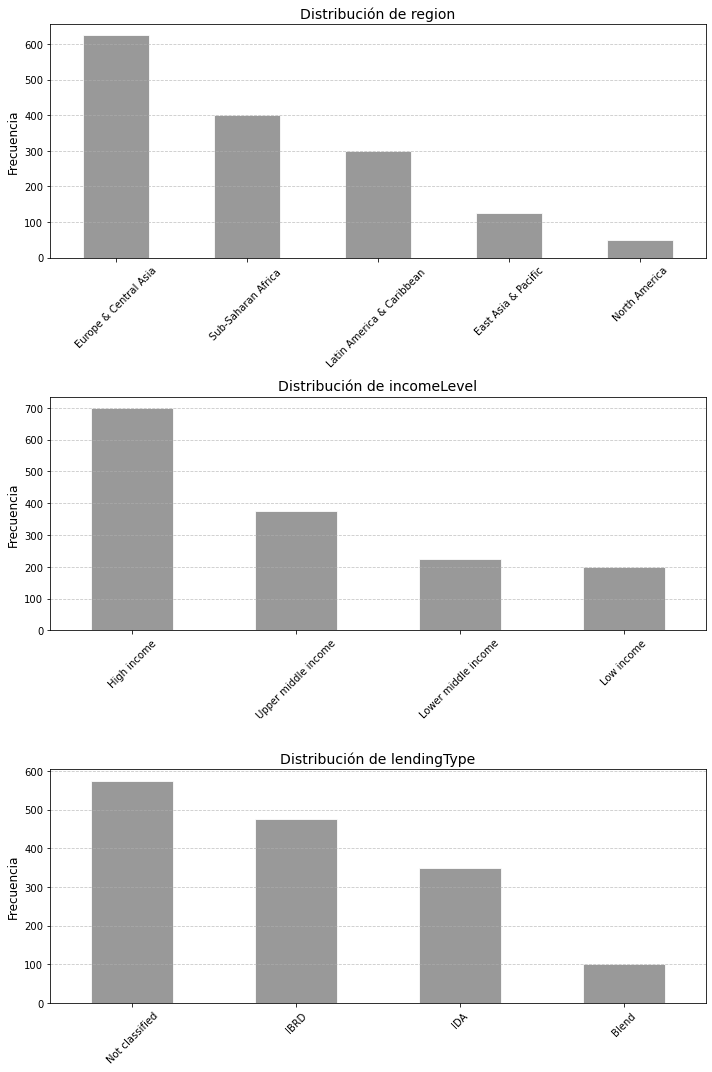

In [38]:

# Variables categóricas a graficar
var_cat_BM = ['region', 'incomeLevel', 'lendingType']
cat_vars = Data[var_cat_BM]

# Crear subplots (uno por variable categórica)
fig, axes = plt.subplots(len(cat_vars.columns), 1, figsize=(10, 5 * len(cat_vars.columns)))

# Asegurar que axes siempre sea iterable
if len(cat_vars.columns) == 1:
    axes = [axes]

# Graficar cada variable
for ax, col in zip(axes, cat_vars.columns):
    counts = Data[col].value_counts(dropna=False)
    counts.plot(kind='bar', ax=ax, color='grey', edgecolor='white', alpha=0.8)

    ax.set_title(f'Distribución de {col}', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas si son largas

plt.tight_layout()
plt.show()

La compilación de las fuentes de datos sobre biodiversidad de GBIF y las variables socioecnómicas del Banco Mundial, resultó en un archivo de 1500 filas y 23 columnas, que representan los valores de 60 países con datos de una serie de tiempo que cubre desde el año 2.000 hasta el 2024. Los datos representan 5 regiones a nivel global, según la clasificación del Banco Mundial, correspondiendo en su mayoría a Europa & Asia Central (42%), África Sub-Sahariana (27%), Latino América & el Caribe (20%), Asia Oriental y el pacífico y Norte América (12%). 

De igual forma, se identifica que la mayoría de los países en la base de datos son de ingresos altos (47%), medios altos (25%), bajos medios (15%) y bajos ingresos (13%). Esto inicialmente podría mostrar una tendencia en el nivel de ingreso de los países que comparten datos e información a través de la red de GBIF. 

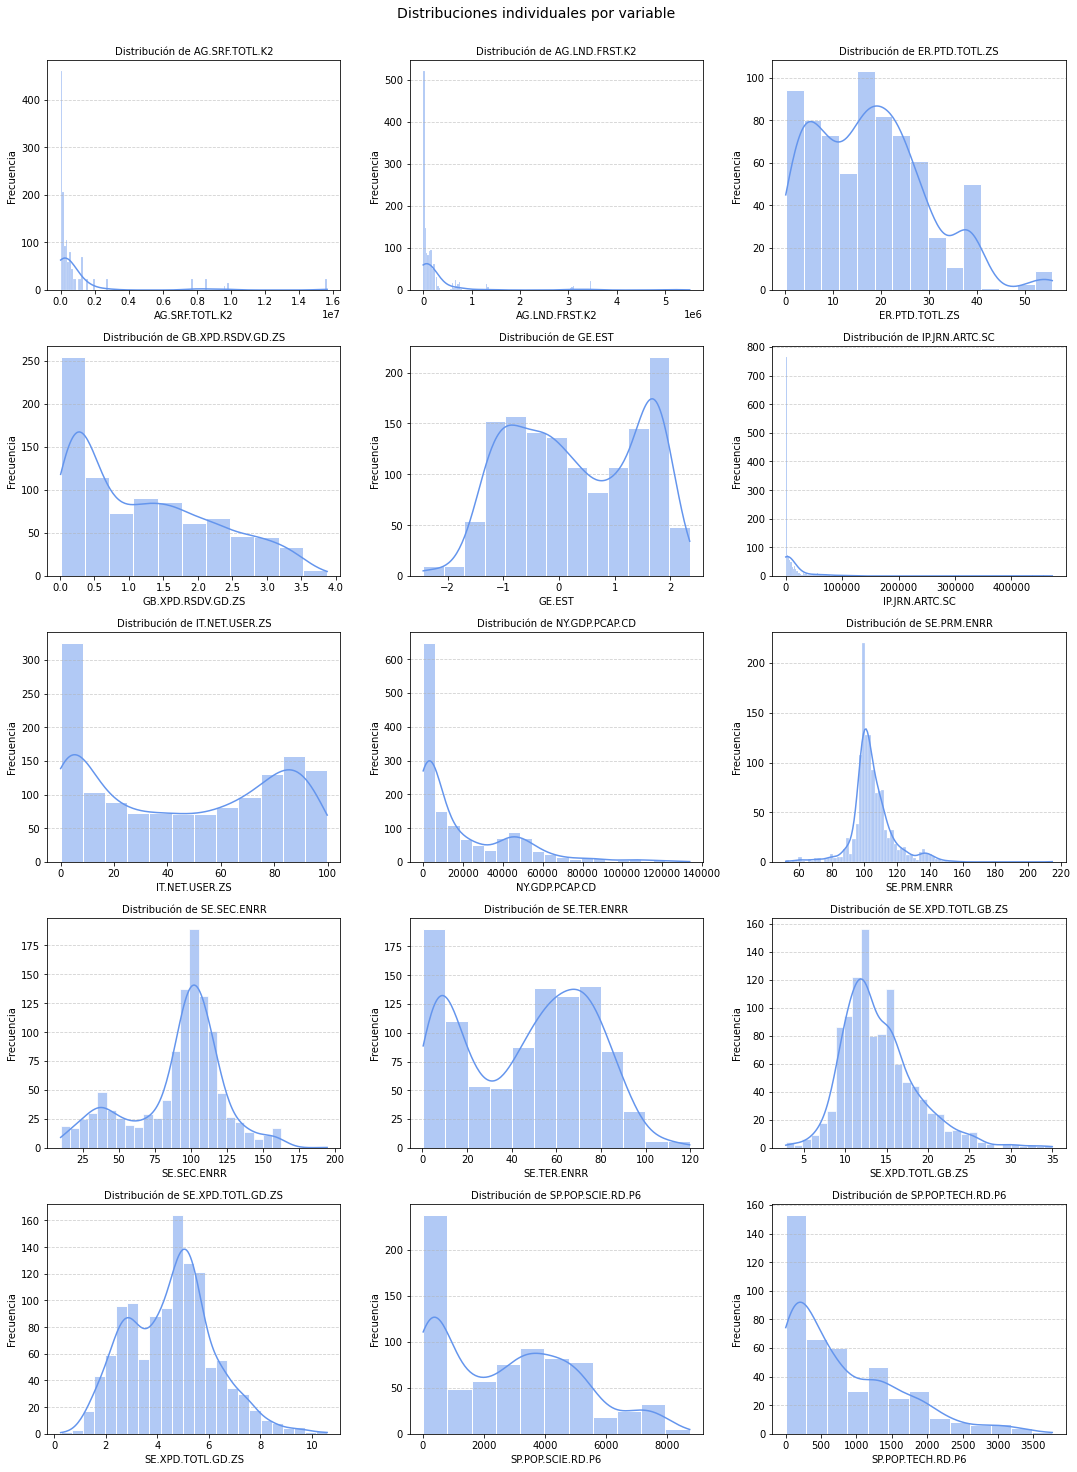

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Número de variables
num_vars = var_BM_se.shape[1]
cols = 3  # Número de columnas en el mosaico
rows = math.ceil(num_vars / cols)

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Crear un histograma + KDE por variable
for i, col in enumerate(var_BM_se.columns):
    sns.histplot(data=var_BM_se, x=col, kde=True, ax=axes[i], color='cornflowerblue', edgecolor='white')
    axes[i].set_title(f'Distribución de {col}', fontsize=10)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribuciones individuales por variable", fontsize=14, y=1.02)
plt.show()


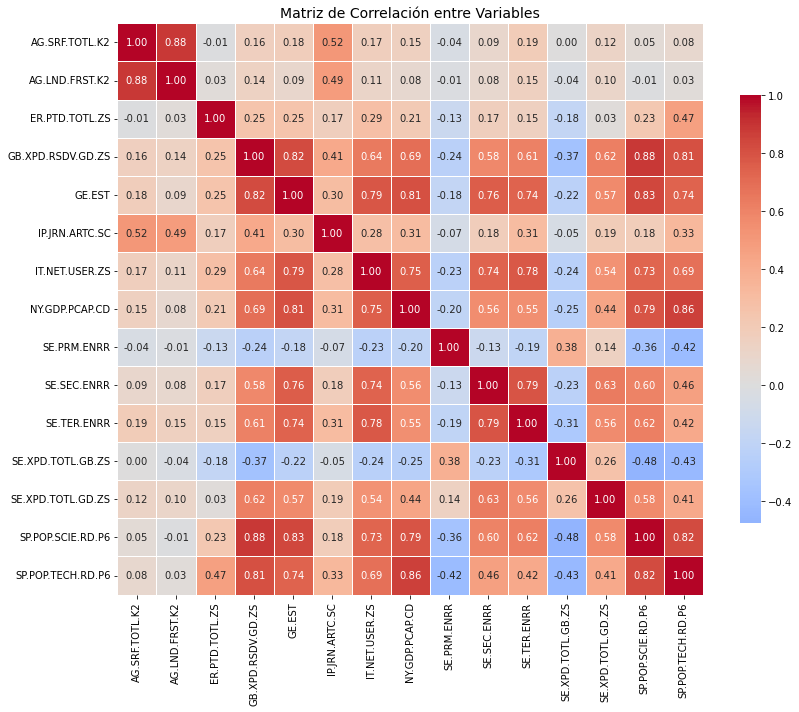

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlaciones
corr_matrix = var_BM_se.corr()

# Crear mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,              # Muestra los valores numéricos
    fmt=".2f",               # Formato de los números
    cmap="coolwarm",         # Paleta de colores
    center=0,                # Centra el color en 0
    linewidths=0.5,          # Líneas divisorias
    cbar_kws={"shrink": 0.75}  # Tamaño de la barra de color
)

plt.title("Matriz de Correlación entre Variables", fontsize=14)
plt.tight_layout()
plt.show()
